# Portfolio Management 

In this work, we use machine learning techniques for portfolio allocation and management.

## Outline

* [1. Introduction](#1)
* [2. Getting Started](#2)
    * [2.1. Import libraries](#2.1)    
    * [2.2. Load Dataset](#2.2)
* [3. Data exploration](#3)
    * [3.1 Descriptive Statistics](#3.1)    
    * [3.2. Data Visualization](#3.2)
* [4. Data Processing](#4)
    * [4.1 Data Cleaning](#4.1)
        * [4.1.1 Asset Returns Calculation](#4.1.1)
    * [4.2 Data Transformation](#3.2)  
        [4.2.1 Check Stationarity](#4.2.1)
* [5. Modeling](#5)        
    * [5.1. Data Splitting](#5.1)
    * [5.2. Performing Eigen decomposition](#5.2)
    * [5.3. Explained Variance](#5.3)
    * [5.4. Computing Portfolio weights](#5.4)
        * [5.4.1 Looking at Portfolio weights](#5.4.1)
    * [5.5 Comparing Portfolios](#5.5)
* [6 Kernel PCA based Portfolios](#6)
* [7 Conclusion](#6)
* [8 References](#7)

    

# 1 - Introduction

In this study, we applied unsupervised machine learning methods to SP500 stock market data over the years 2000-2013. The dataset can be downloaded from Yahoo Finance. 

We started by computing the returns and the correlation between the assets and performing a spectral decomposition of the correlation of the assets.

# 2 - Getting Started

## 2.1 - Import libraries


In [1]:
import os
import numpy as np
import pandas as pd
import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from matplotlib import style
import sklearn as sklearn
from utils import *
from sklearn.decomposition import KernelPCA

%matplotlib inline
sns.set_style("whitegrid")

## 2.2 - Load Dataset



In [2]:
url = 'data/sp500_data.csv'
date_parser = lambda dt: pd.to_datetime(dt, 
                            format='%Y-%m-%d')
stock_prices = pd.read_csv(url, date_parser= date_parser,
                            index_col = 0).dropna()

In [3]:
stock_prices.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,SPX
2000-12-29,36.8889,75.0251,1.0625,12.2505,21.6777,29.0938,51.1875,14.2857,49.8902,6.7344,...,5.6699,13.7418,68.6843,46.1509,17.2992,35.7533,20.3022,118.5000,14.9344,1320.28
2001-01-02,34.2781,72.2256,1.0625,12.1141,21.5378,23.3672,47.0000,13.9286,48.9052,6.4219,...,5.8199,13.4063,66.8280,44.6280,16.6824,35.9933,19.9199,115.8333,14.2602,1283.27
2001-01-03,37.8154,73.2055,1.1696,12.3567,21.0623,28.9688,54.5000,13.3333,47.8710,6.8281,...,7.0199,13.2525,68.6843,42.2743,16.7705,37.9129,20.6845,110.5000,14.4158,1347.56
2001-01-04,39.2471,75.5850,1.2188,11.3408,19.1323,26.8750,52.1250,13.3929,44.6697,7.3281,...,7.1099,12.5116,65.8998,39.0899,16.3299,37.7929,21.6704,104.0000,14.7269,1333.34
2001-01-05,37.0995,74.1853,1.1696,10.9466,19.2442,25.7500,47.6250,13.1548,43.2415,7.2500,...,6.7799,12.2740,65.2810,38.7206,15.9775,34.9734,21.0265,110.1667,14.2084,1298.35


# 3 - Data exploration

## 3.1 - Descriptive Statistics

We will check for the NAs in the rows, either drop them or fill them with the mean of the nearest neighbors



In [4]:
#Checking for any null values and removing the null values
print('Null Values =',stock_prices.isnull().values.any())

Null Values = False


## 3.2 - Data Visualization

Visualizing the price evolution of the SP500 index 


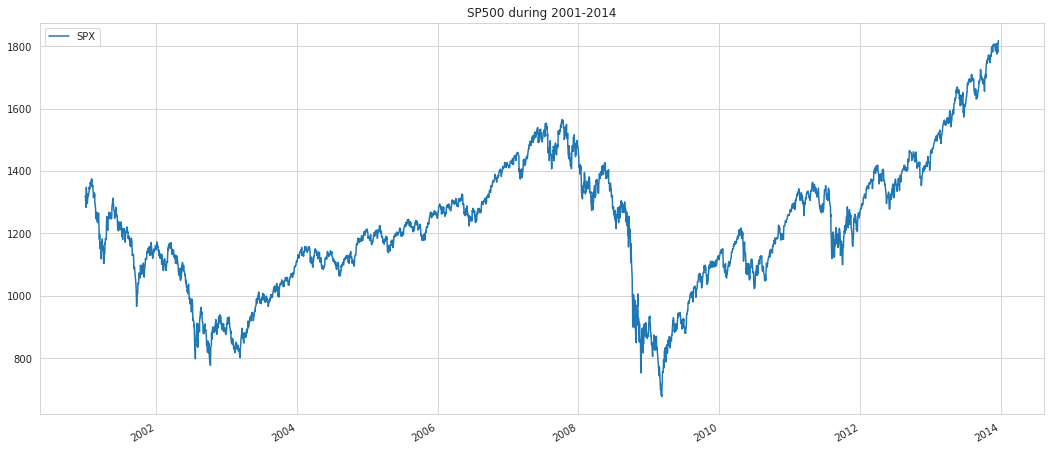

In [5]:
plt.figure(figsize=(18, 8))
plt.title("SP500 during 2001-2014")
stock_prices.SPX.plot()
plt.grid(True);
plt.legend()
plt.show()

# 4 - Data Processing

## 4.1 - Data Cleaning

### 4.1.1 - Asset Returns Calculation

Computing Daily Return
\begin{equation}
R_{t} = \frac{(P_{t+1}-P_{t})}{P_{t}}
\end{equation}


In [6]:
# Daily Log Returns (%)
# datareturns = np.log(stock_prices / stock_prices.shift(1)) 

# Daily Linear Returns (%)
asset_returns = stock_prices.pct_change()
asset_tickers = asset_returns.columns.values[:-1]


In [7]:
data_raw = asset_returns
data_raw.dropna(how='all', inplace=True)

In [8]:
data_raw.describe()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,SPX
count,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,...,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000,3258.000000
mean,0.000382,-0.000002,0.001647,0.000684,0.000280,0.000612,0.000333,0.000562,0.000230,0.000976,...,0.000543,0.000635,0.000324,0.000057,0.000442,0.000298,0.000236,0.000288,0.000753,0.000184
std,0.026511,0.027225,0.025559,0.017244,0.014736,0.027980,0.026144,0.021019,0.015757,0.026994,...,0.023706,0.019467,0.028690,0.019960,0.014485,0.033046,0.027598,0.034921,0.033815,0.013103
min,-0.248775,-0.160538,-0.179198,-0.115857,-0.161377,-0.297579,-0.170324,-0.168285,-0.235792,-0.187175,...,-0.153694,-0.126570,-0.491493,-0.173530,-0.266792,-0.160849,-0.239712,-0.466905,-0.177193,-0.090350
25%,-0.011502,-0.012942,-0.011820,-0.007780,-0.007252,-0.012243,-0.012705,-0.009662,-0.007197,-0.012672,...,-0.011485,-0.009259,-0.010999,-0.010092,-0.006022,-0.017505,-0.010075,-0.013908,-0.017670,-0.005471
50%,0.000345,0.000000,0.000971,0.000655,0.000177,0.000345,0.000000,0.000562,0.000228,0.000837,...,0.000000,0.000246,0.000000,0.000000,0.000618,-0.000599,0.000000,0.000000,0.000467,0.000669
75%,0.012329,0.012833,0.014860,0.009701,0.007683,0.013007,0.011869,0.010885,0.007678,0.014237,...,0.012215,0.010649,0.012145,0.011052,0.007346,0.016787,0.010008,0.013495,0.018895,0.006085
max,0.220586,0.232110,0.139045,0.102207,0.124661,0.239721,0.159574,0.173378,0.118274,0.161340,...,0.206189,0.176813,0.447489,0.141085,0.114587,0.188919,0.394078,0.550117,0.244435,0.115800


The SP500 index returns are presented below, is possible to observe the volatility clustering in the data, in the 2008-2009 has a higher volatility due the crisis.


<Axes: >

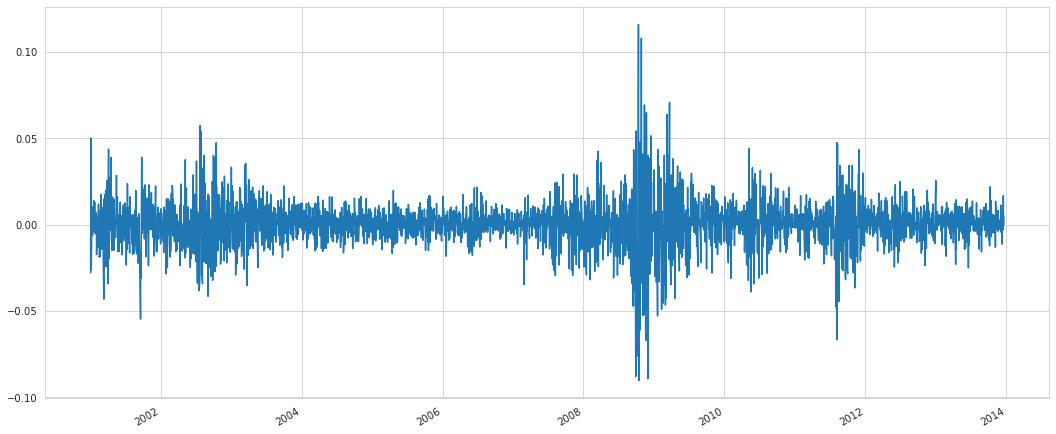

In [9]:
data_raw['SPX'].plot(figsize=(18,8))

## 4.2 - Data Transformation

All the variables should be on the same scale before perform eigendecomposition, otherwise a feature with large values will dominate the result. One way, is to standardize the datasets's features into unit scale with zero mean and unitary variance.


In [10]:
normed_returns = (asset_returns - asset_returns.mean()) / asset_returns.std()
normed_returns.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,SPX
2001-01-02,-2.684053,-1.370515,-0.064454,-0.685327,-0.456949,-7.056602,-3.141807,-1.216032,-1.267636,-1.755202,...,1.093096,-1.286794,-0.953335,-1.656097,-2.491991,0.194111,-0.690867,-0.652654,-1.357300,-2.153355
2001-01-03,3.878093,0.498428,3.879286,1.121694,-1.517195,8.545681,6.090943,-2.060161,-1.356721,2.307050,...,8.675032,-0.621957,0.956891,-2.645198,0.334092,1.604842,1.382229,-1.326712,0.300409,3.809303
2001-01-04,1.413682,1.194016,1.581340,-4.807326,-6.237289,-2.605056,-1.679559,0.185921,-4.258770,2.676560,...,0.517922,-2.904506,-1.424375,-3.776812,-1.844252,-0.104798,1.718479,-1.692694,0.615919,-0.819376
2001-01-05,-2.078466,-0.680114,-1.643812,-2.055371,0.377902,-1.517951,-3.314843,-0.872576,-2.043761,-0.430977,...,-1.980859,-1.008158,-0.338601,-0.476178,-1.520312,-2.266576,-1.085197,1.689713,-1.063455,-2.016781
2001-01-08,-1.256048,0.554483,0.383791,3.494389,-0.709449,-1.366377,-1.317823,2.987048,4.611569,-0.275807,...,-1.142864,-0.091231,1.145087,1.072129,1.999889,2.638199,-1.048720,0.728217,0.733257,-0.160413


## 4.2.1 - Check Stationarity

We need to confirm that the time series of the combined data is stationary and that it does not contain any trends or seasonal effects. We can use the Augmented Dickey-Fuller test to check if the series is stationary. The null hypothesis of this test, states that the time series can be represented by a "unit root", i.e. it has some time dependent structure. Rejecting this null hypothesis means that the time series is stationary. If the ADF test statistic is < -4 then we can reject the null hypothesis - i.e. we have a stationary time series.

In [11]:
# check if the time series is stationary 

# ADF test to check for stationary in data 
result = adfuller(asset_returns.iloc[:,100].dropna())
print('ADF Statistic: %f' % result[0])
print('Critical Values @ 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])

ADF Statistic: -13.644064
Critical Values @ 0.05: -2.86
p-value: 0.000000


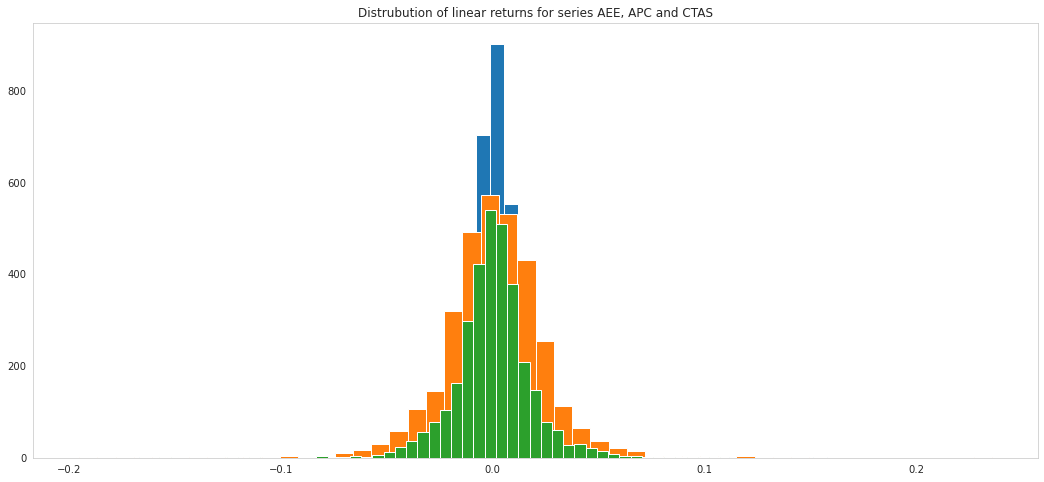

In [12]:
#plot a particular series - if it is approximately normal then there is a good chance we have a stationary series
plt.figure(figsize=(18,8))
asset_1, asset_2, asset_3 = asset_returns.iloc[:,10], asset_returns.iloc[:,30], asset_returns.iloc[:,85]
plt.hist(asset_1.dropna(),bins=50,)
plt.hist(asset_2.dropna(),bins=50)
plt.hist(asset_3.dropna(),bins=50)
plt.title("Distrubution of linear returns for series %s, %s and %s" % (asset_1.name, asset_2.name, asset_3.name))
plt.grid(which='major')
plt.show()

Taking a look at the correlation between the first 50 assets. The assets are ordered alphabetically.

<Axes: title={'center': 'Correlation Matrix between the returns'}>

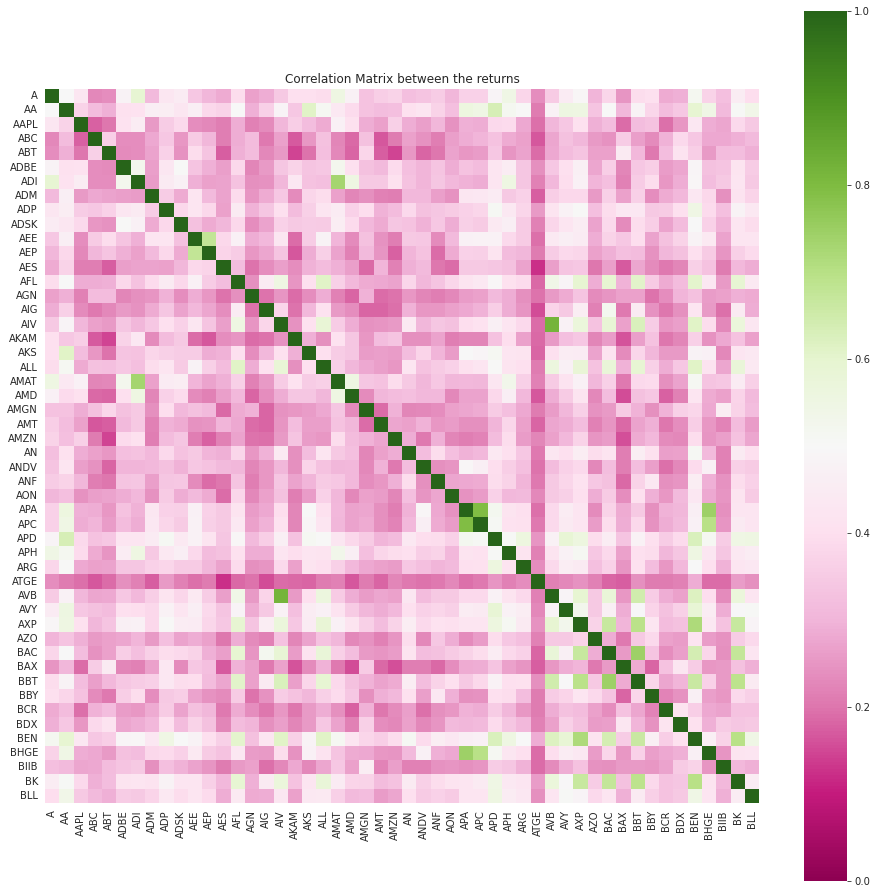

In [13]:
# correlation
correlation = asset_returns[asset_tickers].corr()
plt.figure(figsize=(16,16))
plt.title('Correlation Matrix between the returns')
sns.heatmap(correlation.iloc[:50,:50], vmin=0, vmax=1 ,fmt=".1f" ,square=True, cmap='PiYG')

# 5 - Modeling

## 5.1. Data Splitting


Dividing the dataset into training and testing sets

In [14]:
train_end = datetime.datetime(2010, 4, 10) 

df_train = None
df_test = None
df_raw_train = None
df_raw_test = None

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (2327, 410)
Test dataset: (931, 410)


## 5.2 Performing Eigen decomposition

Principal component analysis (PCA) is a popular technique used in data science to reduce the dimensionality of the data while retaining as much information as possible. The principal components of the covariance matrix capture the most information about the dataset whenever it is projected onto that vector.

The eigenvalue that corresponds to that eigenvector corresponds to the magnitude of the eigenvector, explaining the variance of the data. The eigenvectors of a PCA decomposition can be treated as principal factor weights. Particularly, they represent asset weights for each principal component portfolio. The total number of principal portfolios is equal to the number of principal components. The range of the loadings can vary from -1 to 1, meaning short sales are allowed.

In asset allocation, PCA can be used to decompose a matrix of covariance into statistical factors. These latent factors may represent unobservable risk factors, which is different from traditional factors from literature. Hence, allocating across these may improve one’s portfolio diversification.

We now look at the first eigen portfolio. We use the definition of eigen portfolios as provided by Avellaneda [1].

Following Avellaneda, we define eigen portfolio weights as:

\begin{equation}
Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i}
\end{equation}

where $j$ is the index of eigen portfolio and $v_i$ is the i-th element of j-th eigen vector.

In [15]:
# Removing SPX index from tickers
asset_tickers = normed_returns.columns.values[:-1]

n_tickers = len(asset_tickers)
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=asset_tickers)
cov_matrix_raw = cov_matrix


asset_tickers = asset_returns.columns.values[:-1]

# computing PCA on S&P 500 stocks
cov_raw = df_raw_train[asset_tickers].cov()
pca = PCA()
pca.fit(cov_raw)


PCA()

## 5.3 - Explained Variance

By standardizing the returns, i.e., extracting the mean and dividing by its variance, we can improve the model's performance. The preprocessing technique enables all the components to have their variance vary in the same range.

In [16]:
# cumulative variance explained
threshold = 0.8
var_explained = np.cumsum(pca.explained_variance_ratio_)
num_comp = np.where(np.logical_not(var_explained < threshold))[0][0] + 1  
print('%d components explain %.2f%% of variance' %(num_comp, 100* threshold))

2 components explain 80.00% of variance


In [17]:
# Computing for normalized returns
cov_matrix = df_train[asset_tickers].cov()
pca.fit(cov_matrix)

# cumulative variance explained
threshold = 0.8
var_explained = np.cumsum(pca.explained_variance_ratio_)
num_comp = np.where(np.logical_not(var_explained < threshold))[0][0] + 1   
print('%d components explain %.2f%% of variance' %(num_comp, 100* threshold))

4 components explain 80.00% of variance


## 5.4 - Computing Portfolio weights

,Explained Variance
0,44.07%
1,63.08%
2,74.48%
3,81.41%
4,84.54%
5,86.23%
6,87.16%
7,87.99%
8,88.68%
9,89.12%


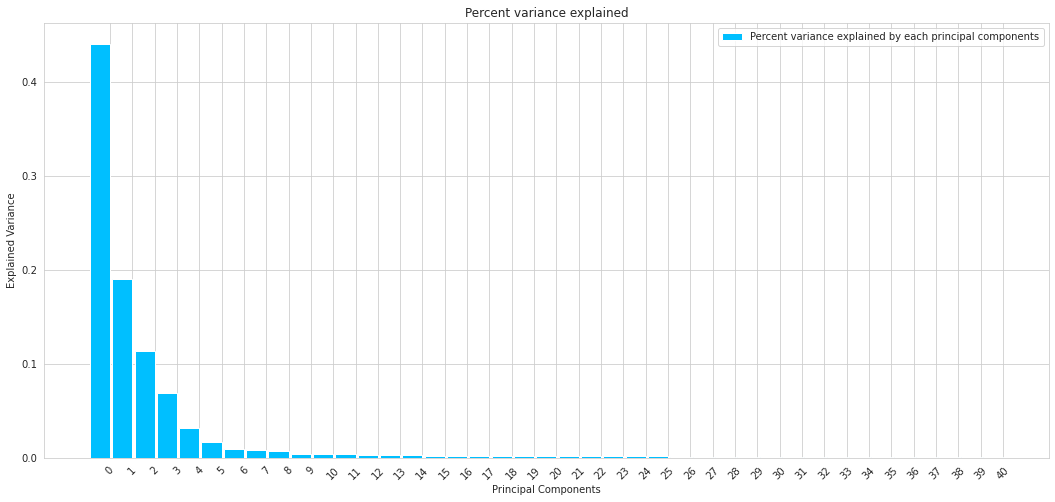

In [18]:
bar_width = 0.9
n_asset = int((1 / 10) * normed_returns.shape[1])
x_indx = np.arange(n_asset)
fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
# Eigenvalues are measured as percentage of explained variance.
rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
ax.set_xticks(x_indx + bar_width / 2)
ax.set_xticklabels(list(range(n_asset)), rotation=45)
ax.set_title('Percent variance explained')
ax.legend((rects[0],), ('Percent variance explained by each principal components',))
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Principal Components')
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(11).style.format('{:,.2%}'.format)


## 5.4.1.Looking at Portfolio weights


array([[<Axes: title={'center': 'Portfolio 0'}>],
       [<Axes: title={'center': 'Portfolio 1'}>],
       [<Axes: title={'center': 'Portfolio 2'}>],
       [<Axes: title={'center': 'Portfolio 3'}>]], dtype=object)

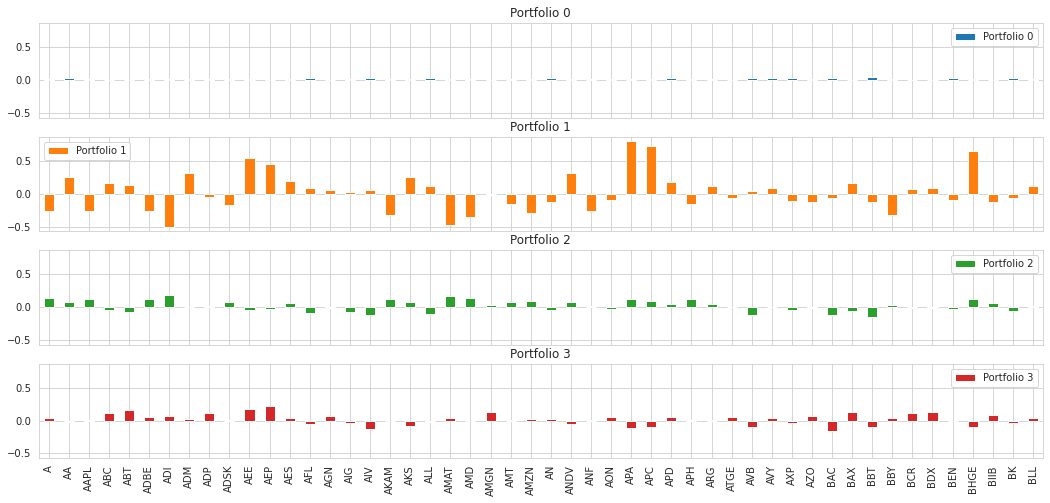

In [19]:
Components_num = 4 
        
sample_portfolio = pd.DataFrame(pca.components_[:Components_num,:50], columns=asset_returns[asset_tickers[:50]].columns)
eigen_portfolios = sample_portfolio.div(sample_portfolio.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( Components_num)]
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(Components_num),1), figsize=(18,8),  sharey=True )

Sum of weights of first eigen-portfolio: 1.00


<Axes: title={'center': 'Eigen-portfolio weights'}>

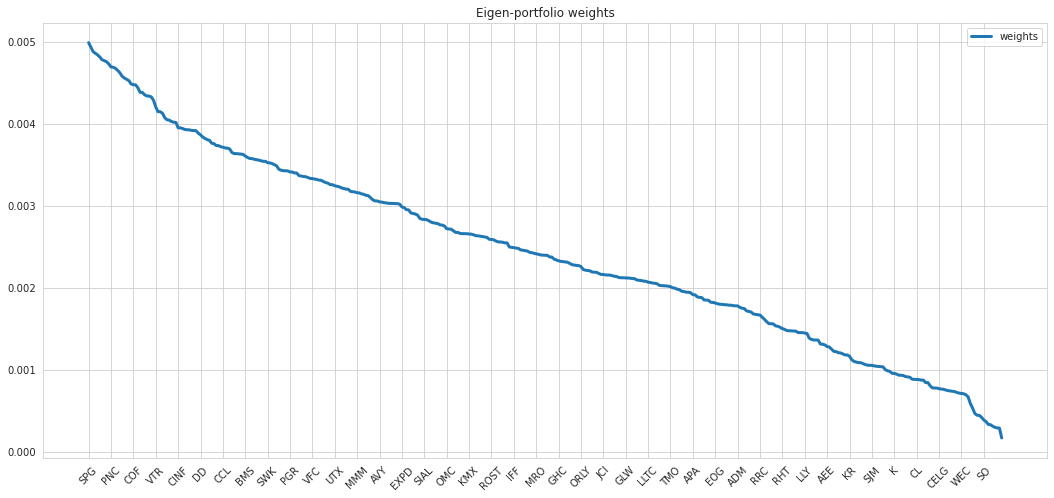

In [20]:
pcs = pca.components_
normalized_pcs = list()

for loading in pcs:
    normalized_values = loading / loading.sum()
    normalized_pcs.append(normalized_values)

    
pc_w = normalized_pcs[0]
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()}, index = asset_tickers)
eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
eigen_prtf1.plot(title='Eigen-portfolio weights', 
                 figsize=(18,8), 
                 xticks=range(0, len(asset_tickers),10), 
                 rot=45, 
                     linewidth=3)

First eigen-portfolio:
Return = 13.55%
Volatility = 20.93%
Sharpe = 0.65


<Axes: title={'center': 'Returns of the market-cap weighted index vs. First eigen-portfolio'}>

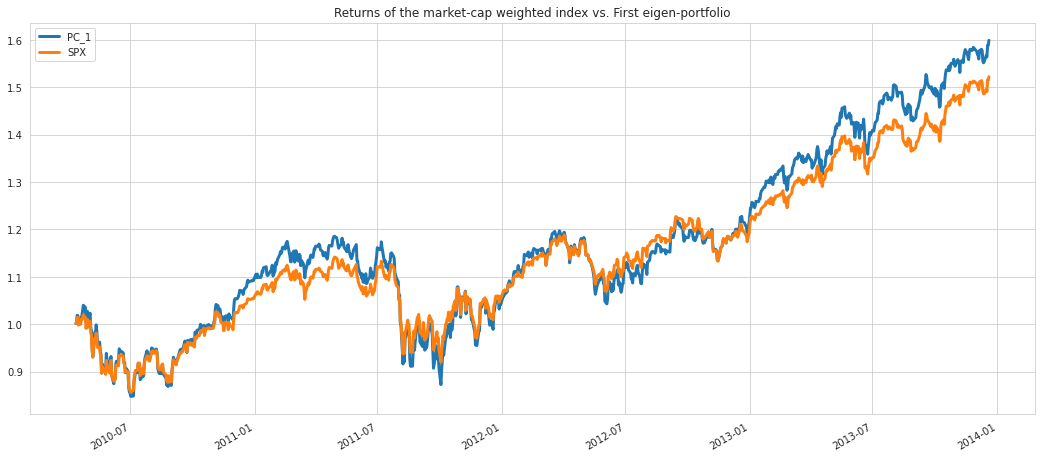

In [21]:
eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 )
eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
df_plot = pd.DataFrame({'PC_1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                         figsize=(18,8), linewidth=3)

## 5.5 - Comparing Portfolios

Following, we perform the same procedure by extracting other principal components. The main hypothesis is that the portfolio with the highest performance in in-sample data will also have good performance in out-of-sample data. We use the Sharpe ratio, which is a performance metric that compares the annualized returns against the annualized volatility of each company in a portfolio. A high Sharpe ratio explains higher returns and/or lower volatility for the specified portfolio. The risk-free rate is considered to be zero. Other metrics can be employed to compare the portfolios, and different metrics may lead to different choices in the leading portfolio.

Eigen portfolio #3 with the highest Sharpe. Return 15.68%, vol = 11.74%, Sharpe = 1.34


Text(0.5, 0, 'Portfolios')

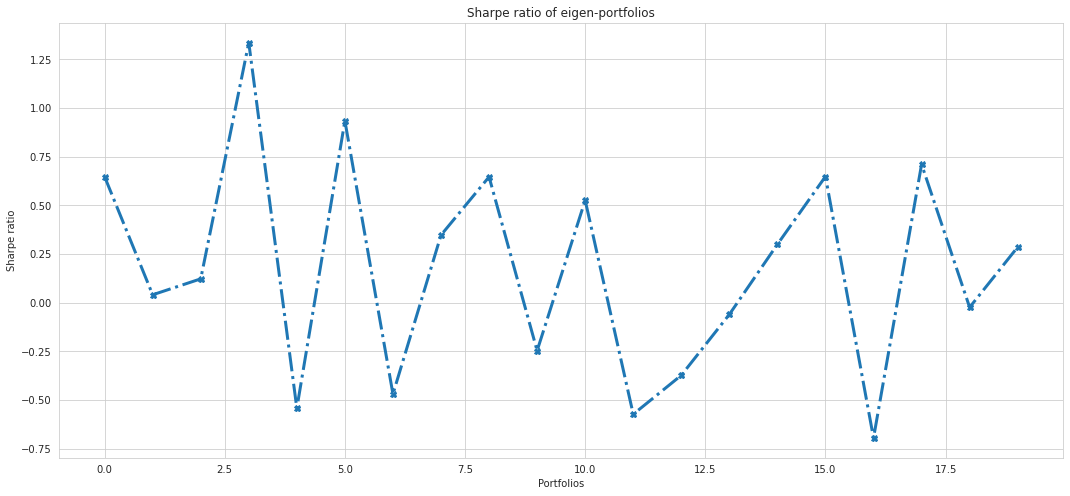

In [22]:
n_portfolios = 20
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0  

for portfolio in range(n_portfolios):

    pc_w = pcs[portfolio,:] / np.sum(pcs[portfolio,:])

    eigen_prtf = pd.DataFrame(data ={'weights': pc_w}, index = asset_tickers)

    eigen_returns = np.dot(df_raw_test.loc[:, eigen_prtf.index], eigen_prtf )
    eigen_returns = pd.Series(eigen_returns.squeeze(), index=df_test.index)

    annualized_ret[portfolio], annualized_vol[portfolio], sharpe_metric[portfolio] = sharpe_ratio( eigen_returns )


sharpe = sharpe_metric[~np.isnan(sharpe_metric)]
max_sharpe = np.amax(sharpe)
index_max_sharpe = np.where(sharpe_metric == max_sharpe)
idx_highest_sharpe = index_max_sharpe[0]

print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
      (idx_highest_sharpe,
       annualized_ret[idx_highest_sharpe]*100, 
       annualized_vol[idx_highest_sharpe]*100, 
       sharpe_metric[idx_highest_sharpe]))

fig, ax = plt.subplots()
fig.set_size_inches(18, 8)
ax.plot(sharpe_metric, linewidth=3,marker='X',linestyle='-.')
ax.set_title('Sharpe ratio of eigen-portfolios')
ax.set_ylabel('Sharpe ratio')
ax.set_xlabel('Portfolios')

In [23]:
results_portfolios = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results_portfolios.sort_values(by=['Sharpe'], ascending=False, inplace=True)

results_portfolios.dropna(inplace=True)
results_portfolios.head(5)


,Return,Vol,Sharpe
3,0.156841,0.117444,1.335446
5,0.265606,0.284330,0.934146
17,0.240103,0.337905,0.710564
15,0.434903,0.671074,0.648070
0,0.135513,0.209343,0.647323


The performance of the portfolio with the highest Sharpe ratio in the training data set is evaluated in the testing data set.

Best eigen-portfolio:
Return = 15.68%
Volatility = 11.74%
Sharpe = 1.34


<Axes: title={'center': 'Returns of the market-cap weighted index vs. Best eigen-portfolio'}>

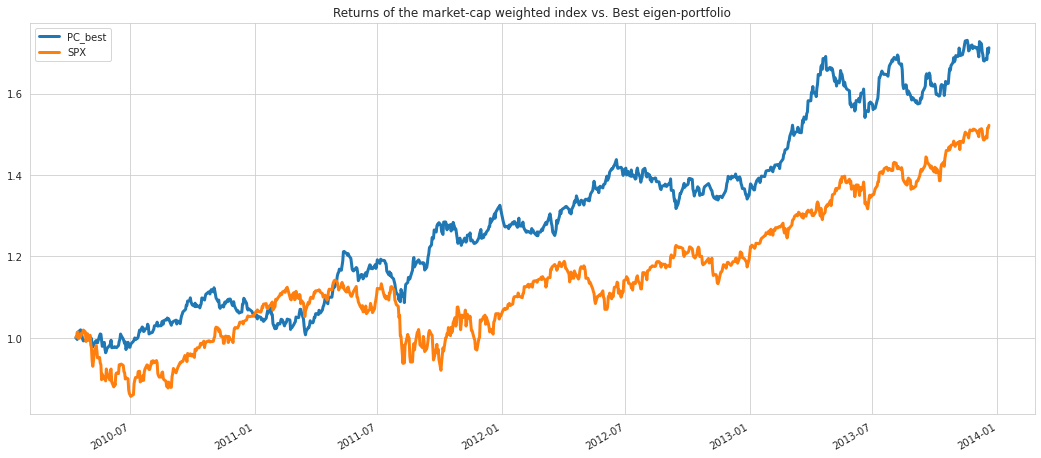

In [24]:
# We compute the annualized return of the best portfolio and graph it out against benchmark
pc_w = normalized_pcs[idx_highest_sharpe[0]]
eigen_prtf_best = pd.DataFrame(data ={'weights': pc_w.squeeze()}, index = asset_tickers)

eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf_best.index], eigen_prtf_best)
eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
print('Best eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))

df_plot = pd.DataFrame({'PC_best': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. Best eigen-portfolio', 
                         figsize=(18,8), linewidth=3)

# 6 - Kernel PCA based Portfolios

Kernel principal component analysis (KPCA) is one type of nonlinear PCA developed by generalizing the kernel method into PCA. This extension of PCA allows for the separability of nonlinear data by making use of kernels. The main idea behind it is to project the linearly inseparable data onto a higher-dimensional space, where it becomes linearly separable. One of the advantages of KPCA over traditional PCA is that it can handle nonlinear relationships between the input features. There are various kernel methods, like linear, polynomial, and gaussian.

We will develop various portfolios using KPCA, and different kernels will be tested. The goal is to obtain an alternative portfolio for traditional PCA, which can increase the diversification of the portfolio and eventually get a higher return or Sharpe ratio. Here, we are using the built-in kernels in the sklearn package; other kernels can be developed and employed for portfolio construction. All the codes for performing the KPCA decomposition and comparison between portfolios can be found in the utils.py file.

In [25]:
kernels = ['linear', 'poly', 'rbf', 'cosine','commum_pca']

portfolios = pd.DataFrame(index=df_raw_test.index, columns=kernels)
for kernel in kernels:
    normalized_pcs = apply_kpca(cov_matrix, kernel)
    best_portfolio = optimizedPortfolio(normalized_pcs,df_raw_test, asset_tickers, plot=False)
    best_return = plot_best_portfolio(best_portfolio.index[0], normalized_pcs,  df_raw_test, asset_tickers, False)
    portfolios.loc[:,kernel] = best_return

Eigen portfolio #12 with the highest Sharpe. Return 16.87%, vol = 18.72%, Sharpe = 0.90
Eigen portfolio #14 with the highest Sharpe. Return 16.31%, vol = 18.22%, Sharpe = 0.90


/tmp/ipykernel_14168/1821479732.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  portfolios.loc[:,kernel] = best_return
/tmp/ipykernel_14168/1821479732.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  portfolios.loc[:,kernel] = best_return


Eigen portfolio #13 with the highest Sharpe. Return 16.78%, vol = 18.23%, Sharpe = 0.92
Eigen portfolio #17 with the highest Sharpe. Return 15.24%, vol = 16.55%, Sharpe = 0.92


/tmp/ipykernel_14168/1821479732.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  portfolios.loc[:,kernel] = best_return
/tmp/ipykernel_14168/1821479732.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  portfolios.loc[:,kernel] = best_return


Eigen portfolio #3 with the highest Sharpe. Return 15.68%, vol = 11.74%, Sharpe = 1.34


/tmp/ipykernel_14168/1821479732.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  portfolios.loc[:,kernel] = best_return


<Axes: title={'center': 'Returns of SP500 index vs. Kernel PCA portfolios'}>

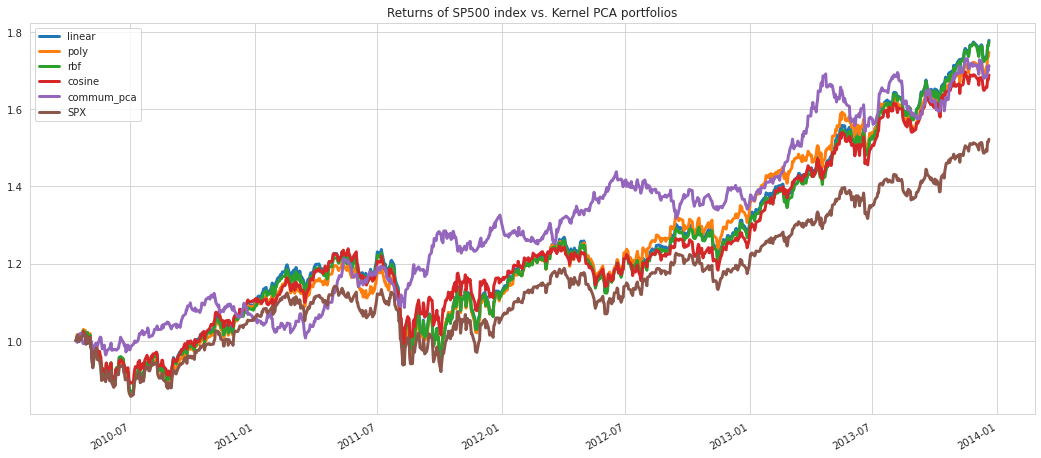

In [26]:
all_portfolios = portfolios.join(df_raw_test.loc[:, 'SPX'])
np.cumprod(all_portfolios + 1).plot(title='Returns of SP500 index vs. Kernel PCA portfolios', 
                         figsize=(18,8), linewidth=3)

All the portfolios with different kernels are plotted against the benchmark, we can see that they are overall really correlated to each other, we can plot the correlation matrix between each portfolio return.

<Axes: title={'center': 'Correlation Matrix between the returns of ML factors'}>

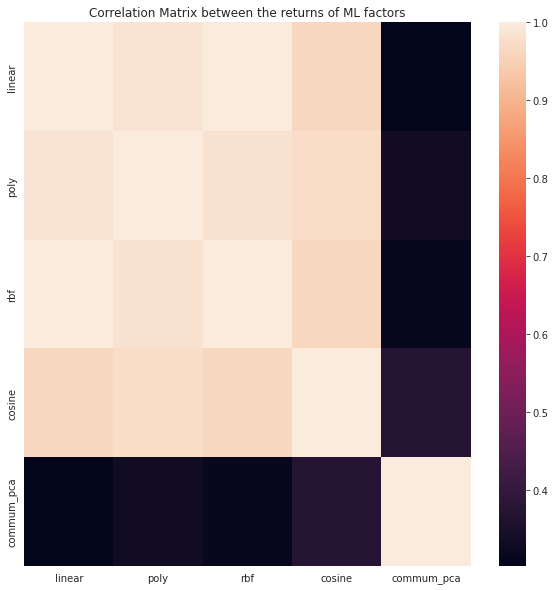

In [27]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix between the returns of ML factors')
sns.heatmap(portfolios.corr())

<Axes: title={'center': 'Returns index vs. PCA and KPCA'}>

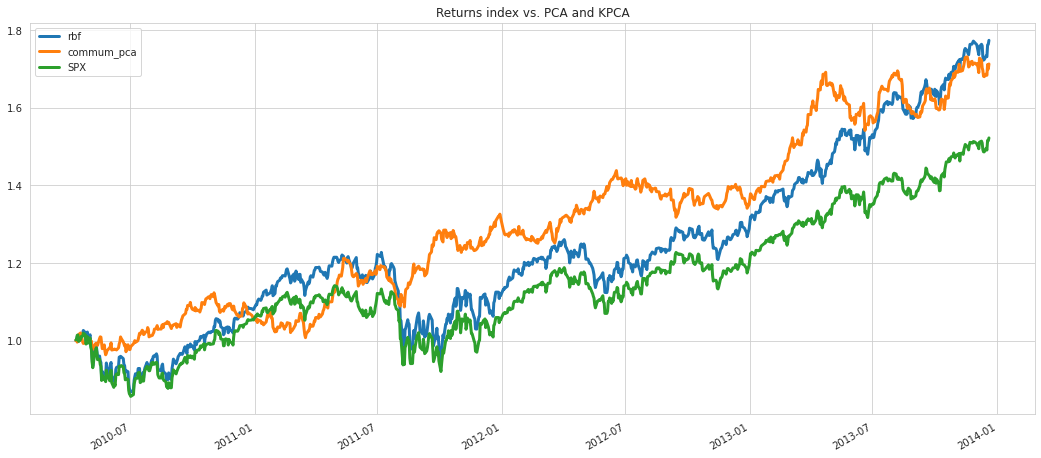

In [28]:
np.cumprod(all_portfolios[['rbf','commum_pca','SPX']] + 1).plot(title='Returns index vs. PCA and KPCA', 
                         figsize=(18,8), linewidth=3)

We select the KPCA model with *rbf*  kernel, because of the low correlation with the PCA portfolio. We combine both of the portfolios with equal weights to create a new diversifided portfolio.

In [29]:
diversified_portfolio = (all_portfolios['commum_pca'] + all_portfolios['rbf'])/2
diversified_portfolio.name = 'diversified'

In [30]:
portfolios = [all_portfolios['rbf'],all_portfolios['commum_pca'],diversified_portfolio ]
port_final = pd.DataFrame(index = ['rbf','commum_pca','diversified'], columns = ['Return', 'Vol', 'Sharpe'])
for port in portfolios:
    er, vol, sharpe = sharpe_ratio(port)
    port_final.loc[port.name] = round(er,2), round(vol,2), round(sharpe,2)

In [31]:
port_final

,Return,Vol,Sharpe
rbf,0.17,0.18,0.92
commum_pca,0.16,0.12,1.34
diversified,0.17,0.12,1.36


By adding a kernel PCA portfolio to a traditional PCA, we diversify our portfolio with linear and non-linear mapping. The combination of the two portfolios implies a higher Sharpe ratio with a minor change in the returns compared with the performance of each of them separately.

# 7 - Conclusion

We presented a systematic approach for constructing factor-free portfolio strategies based on eigen-decomposition. The presented approach is based on eigen decomposing of empirical covariances of stock returns into systematic components. Each component by construction is independent of the others, which can benefit the portfolio with diversification through their inclusion. The first eigen portfolio can be seen as the market factor and has similar behavior to the market. By examining the backtesting result, the portfolio with the highest Sharpe ratio in the training set leads to a portfolio that outperforms the market. By using eigen decomposition, we may obtain independent portfolios with a higher return and Sharp ratio as compared to the market.

# 8 - References

##### [1] Avellaneda, Marco, and Jeong-Hyun Lee. "Statistical arbitrage in the US equities market." Quantitative Finance 10.7 (2010): 761-782.